In [126]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import h5py

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn import metrics
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [127]:

#defining the background categories that we'd like to include in analysis, each background has a .hdf5 file
bkg  = ["Diboson", "Higgs", "Wjets", "Zjets", "singleTop", "topX", "ttbar"]
#bkg  = ["Higgs", "singleTop"]


#create a dic of the bkg processes, process :  pandas dataframe

frames = []
Data_bkg = {}
for process in bkg:
    frame = pd.read_hdf(process + ".hdf5")
    Data_bkg[process] = frame
    frames.append(frame)

#reading the signal .hdf5 file
signal = pd.read_hdf('SUSYC1C1.hdf5')
print(list(signal.columns))


"""these are the differet free parameter mass values that are Simulated in the atlas Open data
"name of the parameterspace" : [channel number, m1, m2 ]
the values of the channel number are from a different file and are hardcoded here"""

parameters = {"m300_m100" : [392504, 300, 100 ],
"m200_m150" : [392502, 200, 150],
"m200_m100" : [392501, 200, 100],
"m400_m300" : [392509, 400, 300],
"m400_m100" : [392507, 400, 100],
"m300_m250" : [392506, 300, 250],
"m600_m300" : [392517, 600, 300],
"m500_m300" : [392513, 500, 300],
"m700_m1" : [392518, 700, 1],
"m700_m300" : [392521, 700, 300]}



"""#Counting the number of occurance of the specfic parameter combination
for item in parameters.keys():
    amount = signal['channel_nr'].value_counts()[parameters[item][0]]
    parameters[item].append(amount)
    parameters[item].append(amount/123954) ##ie the precentage of the total, hard coded 
    print(parameters[item], amount)

    """
#giving an equal distribution 

for item in parameters.keys():
    amount = signal['channel_nr'].value_counts()[parameters[item][0]]
    parameters[item].append(amount)
    parameters[item].append(0.10) ##ie equal distribution 
    print(parameters[item], amount)


['lep1_pt', 'lep2_pt', 'lep1_eta', 'lep2_eta', 'lep1_phi', 'lep2_phi', 'lep1_ch', 'lep2_ch', 'lep1_type', 'lep2_type', 'et', 'channel_nr', 'phi', 'jet_n', 'mcw', 'lep1_mass', 'lep2_mass', 'ev_mll', 'met_pt', 'met_phi', 'ev_mt2']
[392504, 300, 100, 14002, 0.1] 14002
[392502, 200, 150, 3915, 0.1] 3915
[392501, 200, 100, 11950, 0.1] 11950
[392509, 400, 300, 12469, 0.1] 12469
[392507, 400, 100, 15442, 0.1] 15442
[392506, 300, 250, 4021, 0.1] 4021
[392517, 600, 300, 15988, 0.1] 15988
[392513, 500, 300, 15104, 0.1] 15104
[392518, 700, 1, 16496, 0.1] 16496
[392521, 700, 300, 14567, 0.1] 14567


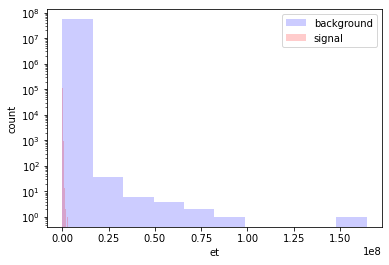

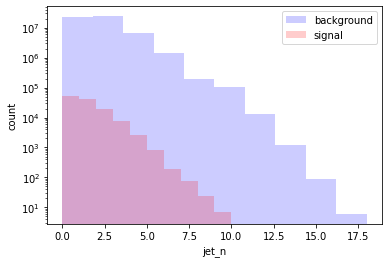

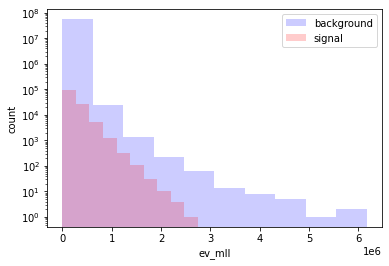

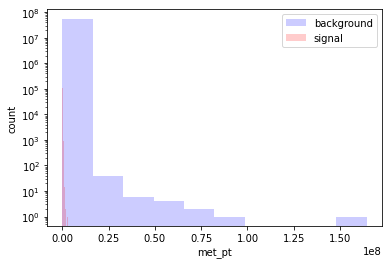

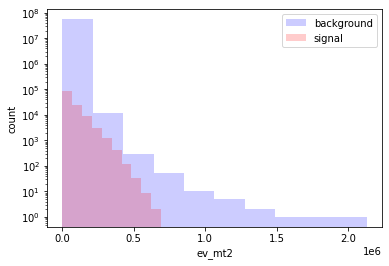

In [128]:
##joining the bkg frames
background = pd.concat(frames, ignore_index=True)

#shuffling the background
background = shuffle(background, random_state=1)





#given background and signals, can plot histograms for selected features
for feature in ['et', 'jet_n','ev_mll', 'met_pt', 'ev_mt2']:
    plt.hist(background[feature], label = "background", color = "blue", alpha = 0.2)
    plt.hist(signal[feature], label = "signal", color = "red", alpha = 0.2)
    plt.xlabel(feature)
    plt.ylabel("count")
    plt.legend()
    plt.yscale("log")
    #plt.xscale("log")
    plt.savefig(f"{feature}_hist.pdf")

    plt.show()



"""here we add the new paramters for the PNN, giving first a deafult value of 1"""
background = background.assign(m1= 1)
background = background.assign(m2= 1)
signal = signal.assign(m1= 1)
signal = signal.assign(m2= 1)


#For the signlas, depending on the channel numbers, setting the free parameters values of m1 and m2
for item in parameters.keys():
    signal.loc[signal.channel_nr == parameters[item][0], 'm1'] = parameters[item][1]
    signal.loc[signal.channel_nr == parameters[item][0], 'm2'] = parameters[item][2]

background = background.sort_index()


In [129]:
##solution to the free parameter
#dividing the background proportionally into the channel number distribution

#based on the distribution precentage, iteratively chosse the specific channel number,
#the panda frame will later be shuffeled

total_elements = background.shape[0]

i = 0
j = 0
m700_m300_index = 0
for item in parameters.keys():
    occur = int(parameters[item][4]*total_elements)
    j += occur
    #print(i, j, occur)
    if item != "m700_m300":
        background.loc[i:j, 'm1'] = parameters[item][1]
        background.loc[i:j, 'm2'] = parameters[item][2]
    else:
        background.loc[i:, 'm1'] = parameters[item][1]
        background.loc[i:, 'm2'] = parameters[item][2]
        m700_m300_index = i
    i = j + 1



#giving the event labels for classification
background = background.assign(label= 0)
signal = signal.assign(label= 1)


In [130]:
#selecting m73 as the channel to interpolate

signal_700_300 = signal[signal.channel_nr == 392521 ]

signal_700_300.to_csv("m73_test.csv", sep='\t')

background_700_300  = background.iloc[m700_m300_index:]

signal = signal[signal.channel_nr != 392521 ]
background = background.iloc[0:m700_m300_index]

print("signal shape: ", signal.shape)
print("bkg shape: ", background.shape)

#preparing training data 
training_data = pd.concat([signal, background], ignore_index=True)
data_700_300 = pd.concat([signal_700_300, background_700_300], ignore_index=True)

#shuffling the data
data = shuffle(training_data, random_state=1)

data_700_300 = shuffle(data_700_300, random_state=1)

y_label = data['label'].values
y_label_700_300 = data_700_300['label'].values


#data = data.loc[:, ~data.columns.isin(['channel_nr', 'label'])]
#data_700_300 = data_700_300.loc[:, ~data_700_300.columns.isin(['channel_nr', 'label', 'mcw',
#'lep1_type', 'lep2_type', 'et', 'phi' ])] 

data_700_300 = data_700_300.loc[:, ~data_700_300.columns.isin(['channel_nr', 'label', 'mcw', 'lep1_type', 'lep2_type', 'et', 'phi'])] 


#scaling
X_73 = data_700_300.values
# scale features
scaler = StandardScaler()
model = scaler.fit(X_73)
X_73 = model.transform(X_73)
xtest73 = torch.from_numpy(X_73).float()
ytest73 = torch.from_numpy(y_label_700_300)


#splitting the data, then writing the individual signal data into files

#X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size= 0.2, random_state=56)

X_train, X_test, y_train, y_test = train_test_split(data, data['label'], test_size= 0.2, random_state=69)


for channel in parameters.keys():
    df = X_test[(X_test.channel_nr == parameters[channel][0]) & (X_test.label == 1) ]
    df.to_csv(f"{channel}_test.csv", sep='\t')

X_test[X_test.label == 0 ].to_csv("background_test.csv", sep='\t')

#X_train = X_train.loc[:, ~X_train.columns.isin(['channel_nr', 'label'])]
#X_test = X_test.loc[:, ~X_test.columns.isin(['channel_nr', 'label'])]


X_train = X_train.loc[:, ~X_train.columns.isin(['channel_nr', 'label', 'mcw', 'lep1_type', 'lep2_type', 'et', 'phi'])]
X_test = X_test.loc[:, ~X_test.columns.isin(['channel_nr', 'label', 'mcw', 'lep1_type', 'lep2_type', 'et', 'phi'])]

y_train = y_train.values
y_test = y_test.values

X_train = X_train.values
X_test = X_test.values


# scale features
scaler = StandardScaler()
model = scaler.fit(X_train)
X_train = model.transform(X_train)

model = scaler.fit(X_test)
X_test = model.transform(X_test)


#to torch tensor
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test)



#for pytorch module, need a Tensordataset type
train_ds = TensorDataset(X_train, y_train)

torch.manual_seed(6)
batch_size = int(2**12)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)



signal shape:  (109387, 24)
bkg shape:  (49357738, 24)


In [131]:
##defining a pytorch network model class

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(17, 10)
        self.layer2 = nn.Linear(10, 1)
        #self.layerF = nn.Linear(15, output_size) #final layer

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        #x = nn.Softmax(dim=1)(x)
        return x

model = Model()
#loss function

#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


torch.manual_seed(3)
num_epochs = 5

def train(model, num_epochs, train_dl, x_valid, y_valid):

    train_loss = [0] * num_epochs
    test_loss = [0] * num_epochs


    for epoch in range(num_epochs):
        start = time.time()
        for x_batch, y_batch in train_dl:  # Dataloader divised into batches

            pred = model(x_batch)[:, 0]
            #print("predicted : ", model(x_batch))
            #print("predicted ", pred)

            loss = loss_fn(pred, y_batch.float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            ##performance
            train_loss[epoch] += loss.item()

        train_loss[epoch] /= len(train_dl.dataset)

        # test performance
        test_pred = model(x_valid)[:, 0]
        test_loss[epoch] = loss_fn(test_pred, y_valid.float()).item()/len(y_valid)
        end = time.time()
        print(f"epoch ", end - start)
        
    
    
    torch.save(model.state_dict(), "model.pt")


    test_pred_data_700_300 = model(xtest73)[:, 0]
    fpr73, tpr73, thresholds73 = metrics.roc_curve(ytest73, test_pred_data_700_300.detach().numpy())


    test_pred = test_pred.detach().numpy()
    fpr, tpr, thresholds = metrics.roc_curve(y_valid.float(), test_pred)
    
    optimalindex = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimalindex]
    print("optimal threshold: ", optimal_threshold )

    roc_fram = {'fpr': fpr, 'tpr': tpr,'thresholds': thresholds }
    roc_fram = pd.DataFrame(data=roc_fram)
    roc_fram.to_csv("PNN.csv", sep='\t')

    roc_fram = {'fpr': fpr73, 'tpr': tpr73, 'thresholds': thresholds73}
    roc_fram = pd.DataFrame(data=roc_fram)
    roc_fram.to_csv("PNN73.csv", sep='\t')

    #print(type(fpr))
    #print(test_pred)
    #print(y_valid)
    #print(thresholds)
    auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = "trained without m1 = 700, m1 = 300 ")
    plt.plot(fpr73, tpr73, label="interpolated m1 = 700, m1 = 300 ")

    plt.plot(list(np.linspace(0, 1, 10)), list(np.linspace(0, 1, 10)), linestyle='dashed')
    plt.text(0.6, 0.25, " auc: %.2f" % round(auc, 2))
    plt.xlabel("FPr")
    plt.ylabel("TPr")
    plt.title("ROC")
    plt.legend()
    plt.savefig("ROC_PNN.pdf")
    plt.show()

    return train_loss, test_loss


epoch  629.9406127929688
epoch  647.691291809082
epoch  643.4315659999847
epoch  642.4130625724792
epoch  642.239196062088
optimal threshold:  0.0026064767


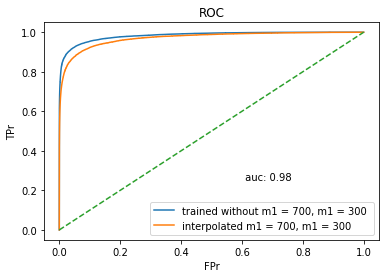

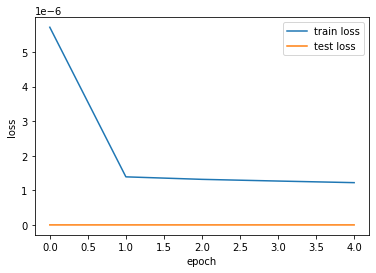

In [132]:
history = train(model, num_epochs, train_dl, X_test, y_test)

plt.plot(history[0], label = "train loss")
plt.plot(history[1], label = "test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig("lossFUNC.pdf")
plt.show()
